In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

### Functions for Tensor Network

In [6]:
def feature_map(p):
    phi = [1-p, p]
    return phi

def data_tensorize(vec):
    data_tensor = [tn.Node(feature_map(p)) for p in vec]
    return data_tensor

In [7]:
def block(*dimensions):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    size = tuple([x for x in dimensions])
    return tf.Variable(
        tf.random.normal(shape=size, dtype=tf.dtypes.float64, mean= 0, stddev = 0.5),
        trainable=True)

def create_blocks(rank, dim, bond_dim, label_dim):
    half = np.int((rank - 2) / 2)
    blocks = [
        block(dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half)] + \
        [ block(bond_dim, label_dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half, rank-2)] + \
        [ block(bond_dim, dim) 
        ]
    return blocks

def create_MPS_labeled(blocks, rank, dim, bond_dim):
    '''Build the MPS tensor'''
    half = np.int((rank - 2) / 2)
    mps = []
    for b in blocks:
        mps.append(tn.Node(b))

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

### Keras custom layer for Tensor Network

In [8]:
class TNLayer(tf.keras.layers.Layer):
    def __init__(self, input_len, label_num, bond_dim):
        self.label_len = 1
        self.label_dim = label_num
        self.rank = input_len
        self.dim = 2
        self.bond_dim = bond_dim
        #super(TNLayer, self).__init__()
        super().__init__()
        # Create the variables for the layer.
        self.blocks = create_blocks(self.rank, self.dim, self.bond_dim, self.label_dim)

    def call(self, inputs):
        def f(input_vec, blocks, rank, dim, bond_dim, label_len):
            mps, edges = create_MPS_labeled(blocks, rank, dim, bond_dim)
            data_tensor = []
            for p in tf.unstack(input_vec):
                data_tensor.append(tn.Node([1-p, p]))
            edges.append(data_tensor[0][0] ^ mps[0][0])
            half_len = np.int(rank / 2)
            [edges.append(data_tensor[i][0] ^ mps[i][1]) for i in range(1, half_len)]
            [edges.append(data_tensor[i-label_len][0] ^ mps[i][1]) \
                 for i in range(half_len + label_len, rank + label_len)]
            for k in reversed(range(len(edges))):
                A = tn.contract(edges[k])
            #result = tf.math.log(A.tensor)
            result = A.tensor - tf.math.reduce_max(A.tensor)
            return result

        result = tf.vectorized_map(
        lambda vec: f(vec, self.blocks, self.rank, self.dim, self.bond_dim, self.label_len), inputs)
        return result

### Create Keras model

In [12]:
label_len = 1
label_num = 10
dim = 2
bond_dim = 5

tf.keras.backend.set_floatx('float64')

tn_model2 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        TNLayer(196, label_num, bond_dim),
        tf.keras.layers.Softmax()
    ],name="sequential_2")

tn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, 14, 14, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 196)               0         
_________________________________________________________________
tn_layer_2 (TNLayer)         (None, 10)                9970      
_________________________________________________________________
softmax_2 (Softmax)          (None, 10)                0         
Total params: 9,970
Trainable params: 9,970
Non-trainable params: 0
_________________________________________________________________


### Train

In [14]:
x_train_2d = x_train[:, :, :, tf.newaxis]

def step_decay(epoch):
    x = 2e-5
    if epoch >= 100:# and epoch <= 200:
        x = 2e-4
    return x

decay = LearningRateScheduler(step_decay, verbose=1)
batch = 32

optimizer = tf.keras.optimizers.Adam()
tn_model2.compile(optimizer=optimizer, 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics = ["accuracy"])
history = tn_model2.fit(x_train_2d, y_train, batch_size=batch, shuffle=True, 
                        steps_per_epoch=int(60000 / batch), epochs=300, 
                        verbose=1, callbacks=[decay])


Epoch 00001: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 1/300
1875/1875 [==============================] - 47s 25ms/step - loss: 2.2854 - accuracy: 0.1112

Epoch 00002: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 2/300
1875/1875 [==============================] - 47s 25ms/step - loss: 2.2559 - accuracy: 0.1368

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 3/300
1875/1875 [==============================] - 48s 25ms/step - loss: 2.2369 - accuracy: 0.1379

Epoch 00004: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 4/300
1875/1875 [==============================] - 48s 26ms/step - loss: 2.2215 - accuracy: 0.1403

Epoch 00005: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 5/300
1875/1875 [==============================] - 47s 25ms/step - loss: 2.2078 - accuracy: 0.1418

Epoch 00006: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 6/300
1875/1875 [==============================] - 47s 

1875/1875 [==============================] - 47s 25ms/step - loss: 2.0569 - accuracy: 0.1826

Epoch 00048: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 48/300
1875/1875 [==============================] - 46s 24ms/step - loss: 2.0566 - accuracy: 0.1840

Epoch 00049: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 49/300
1875/1875 [==============================] - 47s 25ms/step - loss: 2.0564 - accuracy: 0.1842

Epoch 00050: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 50/300
1875/1875 [==============================] - 48s 26ms/step - loss: 2.0562 - accuracy: 0.1852

Epoch 00051: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 51/300
1875/1875 [==============================] - 48s 25ms/step - loss: 2.0560 - accuracy: 0.1858

Epoch 00052: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 52/300
1875/1875 [==============================] - 47s 25ms/step - loss: 2.0558 - accuracy: 0.1869

Epoch 00053: LearningRateSchedu

1875/1875 [==============================] - 45s 24ms/step - loss: 1.9693 - accuracy: 0.2581

Epoch 00095: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 95/300
1875/1875 [==============================] - 45s 24ms/step - loss: 1.9569 - accuracy: 0.2688

Epoch 00096: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 96/300
1875/1875 [==============================] - 47s 25ms/step - loss: 1.9438 - accuracy: 0.2748

Epoch 00097: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 97/300
1875/1875 [==============================] - 46s 25ms/step - loss: 1.9306 - accuracy: 0.2795

Epoch 00098: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 98/300
1875/1875 [==============================] - 46s 25ms/step - loss: 1.9159 - accuracy: 0.2844

Epoch 00099: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 99/300
1875/1875 [==============================] - 48s 26ms/step - loss: 1.9019 - accuracy: 0.2897

Epoch 00100: LearningRateSchedu

1875/1875 [==============================] - 47s 25ms/step - loss: 0.5763 - accuracy: 0.8264

Epoch 00141: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 141/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.5624 - accuracy: 0.8302

Epoch 00142: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 142/300
1875/1875 [==============================] - 48s 25ms/step - loss: 0.5511 - accuracy: 0.8333

Epoch 00143: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 143/300
1875/1875 [==============================] - 48s 25ms/step - loss: 0.5400 - accuracy: 0.8380

Epoch 00144: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 144/300
1875/1875 [==============================] - 48s 26ms/step - loss: 0.5283 - accuracy: 0.8414

Epoch 00145: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 145/300
1875/1875 [==============================] - 46s 24ms/step - loss: 0.5185 - accuracy: 0.8448

Epoch 00146: Learning

1875/1875 [==============================] - 47s 25ms/step - loss: 0.3170 - accuracy: 0.9050

Epoch 00187: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 187/300
1875/1875 [==============================] - 48s 25ms/step - loss: 0.3156 - accuracy: 0.9056

Epoch 00188: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 188/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.3136 - accuracy: 0.9060

Epoch 00189: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 189/300
1875/1875 [==============================] - 48s 26ms/step - loss: 0.3119 - accuracy: 0.9073

Epoch 00190: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 190/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.3109 - accuracy: 0.9076

Epoch 00191: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 191/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.3073 - accuracy: 0.9084

Epoch 00192: Learning

1875/1875 [==============================] - 46s 24ms/step - loss: 0.2336 - accuracy: 0.9281

Epoch 00233: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 233/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.2324 - accuracy: 0.9294

Epoch 00234: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 234/300
1875/1875 [==============================] - 48s 25ms/step - loss: 0.2318 - accuracy: 0.9291

Epoch 00235: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 235/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.2295 - accuracy: 0.9298

Epoch 00236: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 236/300
1875/1875 [==============================] - 48s 25ms/step - loss: 0.2305 - accuracy: 0.9293

Epoch 00237: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 237/300
1875/1875 [==============================] - 46s 25ms/step - loss: 0.2292 - accuracy: 0.9293

Epoch 00238: Learning

1875/1875 [==============================] - 48s 25ms/step - loss: 0.2008 - accuracy: 0.9385

Epoch 00279: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 279/300
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2003 - accuracy: 0.9381

Epoch 00280: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 280/300
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1998 - accuracy: 0.9376

Epoch 00281: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 281/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1986 - accuracy: 0.9386

Epoch 00282: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 282/300
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1992 - accuracy: 0.9392

Epoch 00283: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 283/300
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1973 - accuracy: 0.9391

Epoch 00284: Learning

### Evaluate

In [30]:
x_test_2d = x_test[:, :, :, tf.newaxis]
train_loss, train_acc = tn_model2.evaluate(x_train_2d, y_train, verbose=0)
test_loss, test_acc = tn_model2.evaluate(x_test_2d, y_test, verbose=0)

In [29]:
print('train loss:{:.3f}'.format(train_loss))
print('train accuracy:{:.3f}'.format(train_acc))
print('test loss:{:.3f}'.format(test_loss))
print('test accuracy:{:.3f}'.format(test_acc))

train loss:0.189
train accuracy:0.941
test loss:0.224
test accuracy:0.935


### Learning curve

(0.0, 1.1)

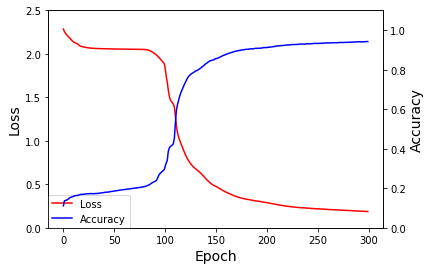

In [15]:
# lr 2e-5 -> 2e-4

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(history.epoch, history.history["loss"],
         color='r', label="Loss")
ax2.plot(history.epoch, history.history["accuracy"], color='b',
        label="Accuracy")
 
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=3, borderaxespad=0.)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
 
ax1.set_ylim([0, 2.5])
ax2.set_ylim([0, 1.1])

### Appendix
For checking initialize condition for MPS

In [54]:
# Retrieving a component

def block(*dimensions, norm=1):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    size = tuple([x for x in dimensions])
    return np.random.normal(loc = 0, scale = 0.5, size = size)

def create_MPS(rank, dim, bond_dim):
    '''Build the MPS tensor'''
    mps = [
        tn.Node( block(dim, bond_dim) )] + \
        [tn.Node( block(bond_dim, dim, bond_dim)) for _ in range(rank-2)] + \
        [tn.Node( block(bond_dim, dim) )
        ]

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank-1):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

def create_MPS_labeled(rank, dim, bond_dim):
    '''Build the MPS tensor'''
    half = np.int((rank - 2) / 2)
    norm = 1 / bond_dim
    mps = [
        tn.Node( block(dim, bond_dim, norm=norm) )] + \
        [tn.Node( block(bond_dim, dim, bond_dim, norm = norm)) for _ in range(half)] + \
        [tn.Node( block(bond_dim, label_dim, bond_dim, norm=norm) )] + \
        [tn.Node( block(bond_dim, dim, bond_dim, norm=norm)) for _ in range(half, rank-2)] + \
        [tn.Node( block(bond_dim, dim, norm=norm) )
        ]

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges


test_vec = x_train[0].flatten()[0:196]
data_tensor = data_tensorize(test_vec)

label_len = 1
label_dim = 10
data_len = len(test_vec)
rank = data_len
dim = 2
bond_dim = 5
# mps, edges = create_MPS(rank, dim, bond_dim)
mps, edges = create_MPS_labeled(rank, dim, bond_dim)


edges.append(data_tensor[0][0] ^ mps[0][0])
half_len = np.int(len(data_tensor) / 2)
[edges.append(data_tensor[i][0] ^ mps[i][1]) for i in range(1, half_len)]
[edges.append(data_tensor[i-label_len][0] ^ mps[i][1]) for i in range(half_len + label_len, data_len + label_len)]
for k in reversed(range(len(edges))):
    A = tn.contract(edges[k])
result = A.tensor

In [55]:
print(A.tensor.numpy())
print(A.tensor.numpy().astype("float32"))
print(tf.math.log(A.tensor).numpy())
print(tf.nn.softmax(A.tensor).numpy())

[-0.00179872 -0.00415382  0.00202591  0.00064367  0.00126495  0.00123817
 -0.00200716  0.00046933 -0.00605777 -0.00103179]
[-0.00179872 -0.00415382  0.00202591  0.00064367  0.00126495  0.00123817
 -0.00200716  0.00046933 -0.00605777 -0.00103179]
[        nan         nan -6.2017354  -7.34832388 -6.67272408 -6.69411802
         nan -7.66420059         nan         nan]
[0.09991393 0.0996789  0.1002968  0.10015826 0.1002205  0.10021782
 0.09989311 0.1001408  0.0994893  0.09999059]
